# Utilize Cycle-StarNet to identify "uknown" lines

This notebook goes through the procedure to correlate elements to lines that are missing from the synthetic line list. We are using the model that has been trained using Payne spectra with noise added (minimum S/N of 50) as the "observed" dataset, which are generated from the entire line list. The "synthetic" spectra used to train the model are also Payne spectra, but many of the lines have been masked in the form of setting them to the continuum level.

Since both domains consist of the same underlying parameters (ie. the stellar labels: $T_{\mathrm{eff}}$, $\log{(g)}$, abundances, etc.) and only differ in the asthetics (ie. missing lines and noise), there is no need to use a *split latent-space*.

In order to identify these "uknown" lines (the masked lines), we need to locate the lines in our observed spectra and determine which element they are most strongly correlated to.

In [1]:
import numpy as np
import h5py
import os
import configparser
from distutils import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

import torch

import sys
sys.path.append('../')
from network import CycleSN
from training_fns import batch_to_cuda, create_synth_batch, CSNDataset
from analysis_fns import apstarwavegrid

model_name = 'new_lines_73'

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

First we will load the model configuration, which consists of the hyper-parameters that define the architecture and training process for this particular model.

In [2]:
# Directories
cur_dir = '..'
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])
emulator_fn = os.path.join(model_dir, config['DATA']['emulator_fn'])


Creating model: new_lines_73

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_synth: csn_kurucz.h5
    data_file_obs: csn_apogee_mock.h5
    emulator_fn: PAYNE.pth.tar
  TRAINING
    batchsize: 8
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    learning_rate_discriminator: 0.0001
    loss_weight_synth: 1e3
    loss_weight_obs: 1e3
    loss_weight_gen: 1
    loss_weight_dis: 1
    lr_decay_batch_iters_rg: [5e4,10e4,15e4,20e4,25e5]
    lr_decay_batch_iters_dis: [5e4,10e4,15e4,20e4,25e5]
    lr_decay_rg: 0.7
    lr_decay_dis: 0.7
    total_batch_iters: 5e5
    use_real_as_true: False
    mask_synth_lines: True
  ARCHITECTURE
    num_pixels: 7167
    activation: LeakyReLU
    conv_filts_ae_dom: [32, 64]
    conv_filt_lens_ae_dom: [7, 7]
    conv_strides_ae_dom: [4, 4]
    conv_filts_ae_sh: [128, 256, 512]
    conv_filt_lens_ae_sh: [7, 7, 7]
    conv_strides_ae_sh: [4, 2, 2]
    conv_filts_ae_sp: [32, 32, 32]
    conv_filt_lens

Now we will create the model architecture which consists of:
- The Emulator, $Payne$, that takes the stellar labels, $y$, as inputs and produces synthetic spectra
- The Endoders, $E_{synth}$ and $E_{obs}$, which take spectra from their respective domains and produce the shared latent-variables, $z_{shared}$
- The Decoders, $D_{synth}$ and $D_{obs}$, which take the shared latent-variables, $z_{shared}$, and produce spectra back into their respective domains 

In [3]:
# BUILD THE NETWORKS

print('\nBuilding networks...')
model = CycleSN(architecture_config, emulator_fn, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(model.emulator)
print('\n\nENCODER_synth and ENCODER_obs ARCHITECTURE:\n')
print(model.encoder_synth)
print('\n\nENCODER_sh ARCHITECTURE:\n')
print(model.encoder_sh)
if model.use_split:
    print('\n\nENCODER_sp ARCHITECTURE:\n')
    print(model.encoder_sp)
    print('\n\nDECODER_sp ARCHITECTURE:\n')
    print(model.decoder_sp)
print('\n\nDECODER_sh ARCHITECTURE:\n')
print(model.decoder_sh)
print('\n\nDECODER_synth and DECODER_obs ARCHITECTURE:\n')
print(model.decoder_synth)
print('\n\nDISCRIM_synth and DISCRIM_obs ARCHITECTURE:\n')
print(model.discriminator_synth)

print('\nLoading saved model...')
# Load pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['cycle_model'])
model.eval_mode()


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER_synth and ENCODER_obs ARCHITECTURE:

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
)


ENCODER_sh ARCHITECTURE:

Sequential(
  (0): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(256, 512, kernel_size=(7,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv1d(512, 25, kernel_size=(1,), stride=(1,))
  (7): InstanceNorm1d(25, eps=1e-05, momentum=0.1, affine=False

Here we will generate a synthetic and observed spectrum from a set of reference labels. The emulator is from the initial Payne training, however, when used as the "synthetic" dataset for training the Cycle-Gan, the lines were masked so that the network did not see these lines throughout training. We will do the same thing here.

In [4]:
# DATA

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load line mask
line_mask = np.load(data_dir+'mock_missing_lines.npz')['total_mask']
line_mask = torch.from_numpy(np.array(line_mask, dtype=np.uint8))

## Choose a set of input labels. 

# The order of the labels are:
# Teff, Logg, Vturb [km/s],
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],
# C12/C13, Vmacro [km/s] 
ref_labels = np.array([[4750., 2.5, 1.5, 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                        0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 7.5, 6.]])
ref_labels = torch.from_numpy(ref_labels.astype(np.float32)) 

# Get an average z_split from the observations as our reference
if model.use_split:
    # A set of observed spectra
    num_spec = 1000
    obs_dataset = CSNDataset(data_file_obs, dataset='val', x_mean=x_mean, 
                                 x_std=x_std, line_mask=None)
    obs_batch = obs_dataset.__getitem__(np.arange(num_spec)) 

    z_split = torch.mean(model.obs_to_z(obs_batch['x'])[1], 0, keepdim=True)
else:
    z_split=None

def y_to_synth(y):

    # Produce synthetic spectrum
    x = model.emulator(y)
    
    # Mask lines
    x[:,line_mask==1]=1.
    
    # Return last 7167 pixels
    return x[:,47:]

def y_to_synth_to_synth(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std
    
    # Encode the synthetic spectrum
    z = model.synth_to_z(x)

    # Decode the latent variables into the synthetic domain
    x = model.z_to_synth(z)
    
    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    
    return x

def y_to_synth_to_obs(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std
    
    # Encode the synthetic spectrum
    z = model.synth_to_z(x)
    
    # Decode the latent variables into the observed domain
    if z_split is not None:
        z_sp = torch.cat(len(y)*[z_split])
        x = model.z_to_obs(z, z_sp)
    else:
        x = model.z_to_obs(z)
    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    
    return x

# Scale labels for emulator input
y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
with torch.no_grad():
    # Create a synthetic spectrum
    x_synth = y_to_synth(y)

    # Create observed spectrum
    x_obs = y_to_synth_to_obs(y)

Plot the two against eachother with and offset on the observed spectrum to see the differences.

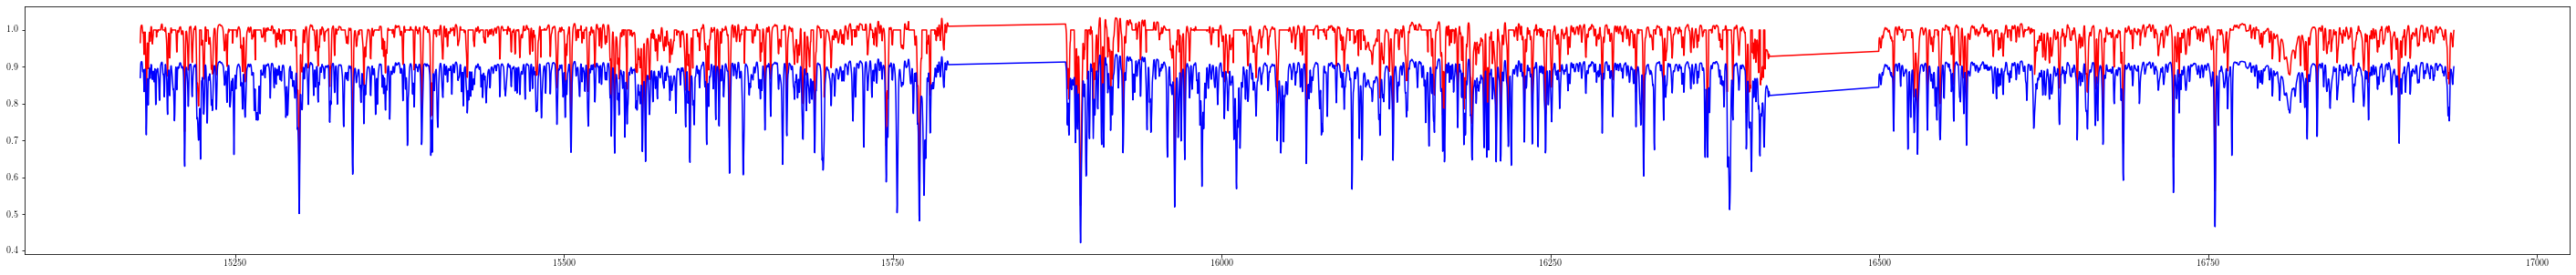

In [5]:
# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()

plt.figure(figsize=(50,5))
plt.plot(wave_grid[47:], x_synth[0].data.numpy(), c='r')
plt.plot(wave_grid[47:], x_obs[0].data.numpy()-0.1, c='b')
plt.show()

Now plot the difference between the two; these are the "missing" lines in our "synthetic" dataset.

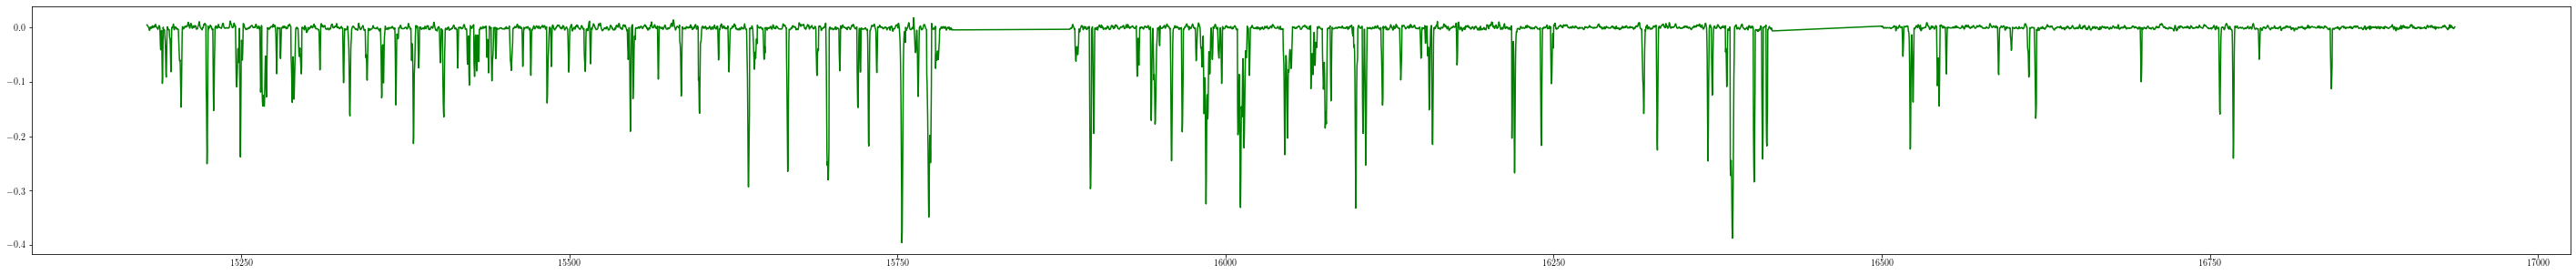

In [6]:
plt.figure(figsize=(50,5))
plt.plot(wave_grid[47:], x_obs[0].data.numpy()-x_synth[0].data.numpy(), c='g')
plt.show()

Now we will calculate the derivatives of both mappings with respect to the input stellar labels and identify the differences between the two. To do this we will create the Jacobian matrix, which is a fancy name for a matrix whose elements consist of the first order partial derivatives of each outputs (the pixels) with respect to each of the inputs (the labels).

For instance, for the emulator, which produces the synthetic spectra, $x_{synth}=Payne(y)$, the Jacobian can be written as

\begin{equation}
\mathbf{J}_{synth}(\mathbf{y},\ \mathbf{w,\ b}) = \begin{bmatrix}
   \frac{\partial x_{synth_{1}}}{\partial y_{1}} &
   \cdots  & \frac{\partial x_{synth_{1}}}{\partial y_{n}} \\
   \vdots & \ddots & \vdots \\
   \frac{\partial x_{synth_{_m}}}{\partial y_{1}} &
   \cdots & \frac{\partial x_{synth_{m}}}{\partial y_{n}}
\end{bmatrix}(\mathbf{y}, \mathbf{w, b})
\end{equation}

where we have $m=7167$ pixels and $n=25$ labels and $\mathbf{w}$ and $\mathbf{b}$ are the weights and biases of the Neural Network.

In [7]:
# Placeholders
jac_synth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))
jac_synthobs  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))

for ele_index in range(25):

    # Deviate reference labels
    deviate_labels = torch.clone(ref_labels)
    deviate_labels[0,ele_index] += 0.05

    # Scale labels for emulator input
    y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
    y_dev = (deviate_labels - model.y_min)/(model.y_max-model.y_min) - 0.5

    # Create a synthetic spectrum
    x_synth = y_to_synth(y).data.numpy()
    x_synth_dev = y_to_synth(y_dev).data.numpy()

    # Create observed spectrum
    x_synthobs = y_to_synth_to_obs(y).data.numpy()
    x_synthobs_dev = y_to_synth_to_obs(y_dev).data.numpy()

    # Calculate difference
    jac_synth[:,ele_index] = x_synth_dev-x_synth
    jac_synthobs[:,ele_index] = x_synthobs_dev-x_synthobs
    
# Only select abundances
jac_synthobs = jac_synthobs[:,3:-2]
jac_synth = jac_synth[:,3:-2]    

Lets make sure that the synthetic derivatives at the masked locations are zero.

In [8]:
np.max(jac_synth[line_mask[47:]==1])

0.0

Now lets check the locations of our masks which should no longer be zero.

In [9]:
np.max(jac_synthobs[line_mask[47:]==1])

0.006119430065155029

We will take the difference of the two to examine the difference between the synthetic output gradients vs. the observed output gradients.

$$\bf{J_{diff} = J_{obs} - J_{synth}}$$

In [10]:
# Calculate difference
jac_diff = jac_synthobs - jac_synth

Yuan-Sen prepared these line masks by calculating the gradients using his own method, which works well. In the **mock_missing_lines.npz** file, there are the gradients for each label as well as the masks for each label. We will use these to help visualize the results.

In [11]:
temp = np.load(data_dir+"mock_missing_lines.npz", allow_pickle=True)

# The assumed missing pixels
gradient_spec = temp["gradient_spec_array"]
start_count_mask = temp["start_count_mask_array"]
start_count = temp["start_count_array"]
end_count_mask = temp["end_count_mask_array"]
end_count = temp["end_count_array"]

We can select a particular element and look at the strong features for that element that are found in the synthetic dataset (black) as well as the lines that are masked (red) and plot our $\bf{J_{diff}}$ along with these. Since $\bf{J_{synth}}$ and $\bf{J_{obs}}$ will be similar for the non-masked lines, we expect the major difference to be apparent where the masked lines are present. Let's check our hypothesis for a couple elements.

First Magnesium:

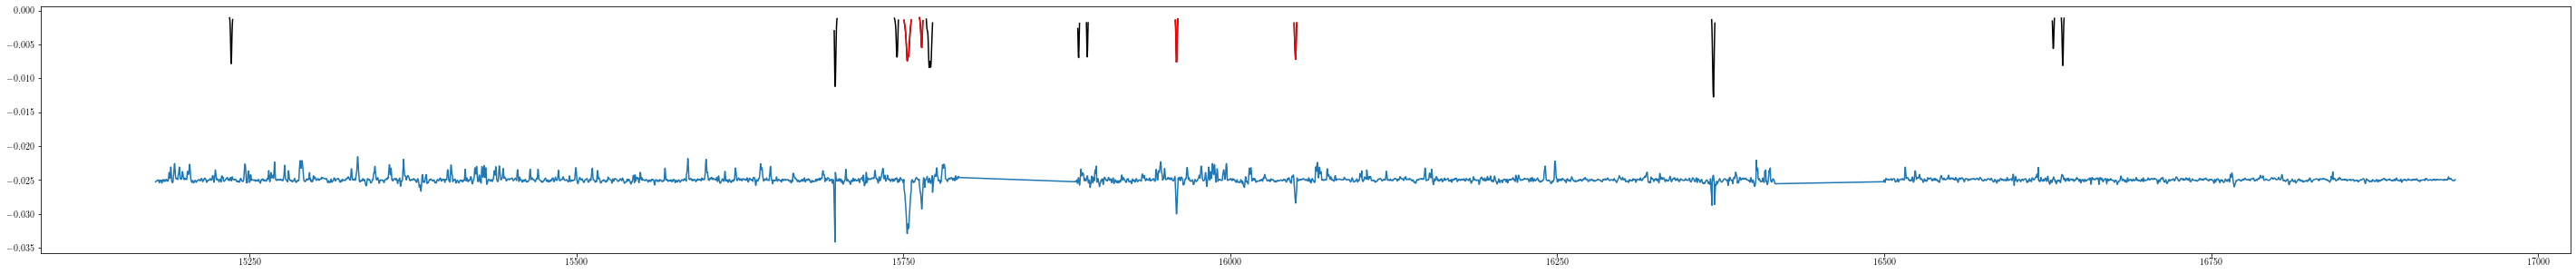

In [12]:
# Choose an element:
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],

ele_index = 4 # [Mg/H]

%matplotlib inline
fig = plt.figure(figsize=(50,5))

# Plot the strong features
for i in range(len(start_count[ele_index])):
    plt.plot(wave_grid[start_count[ele_index][i]:end_count[ele_index][i]],
             gradient_spec[ele_index][start_count[ele_index][i]:end_count[ele_index][i]],
             color="black")
    
# Plot pixels that got masked out
for i in range(len(start_count_mask[ele_index])):
    plt.plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
             gradient_spec[ele_index][start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
             color='r')
    
# Plot the difference derivative between the observed output and the synthetic output (ie. J_diff)
plt.plot(wave_grid[47:], jac_diff[:,ele_index]-0.025)
    
plt.show()

Clearly, the 4 of the most prominent dips in $\bf{J_{diff}}$ are at the locations of the masked lines, however, one of the non-masked lines appears to have more importance in the $y\rightarrow x_{synth}\rightarrow x_{obs}$ mapping than the $y\rightarrow x_{synth}$ mapping.

Let's try this again for Aluminum:

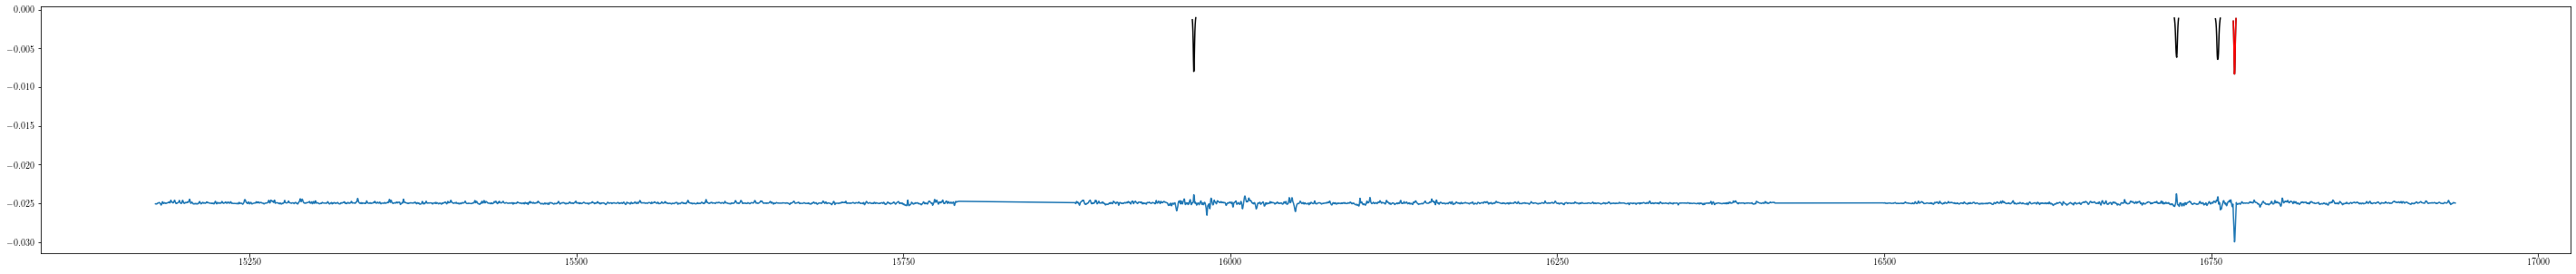

In [13]:
# Choose an element:
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],

ele_index = 5 # [Al/H]

%matplotlib inline
fig = plt.figure(figsize=(50,5))

# Plot the strong features
for i in range(len(start_count[ele_index])):
    plt.plot(wave_grid[start_count[ele_index][i]:end_count[ele_index][i]],
             gradient_spec[ele_index][start_count[ele_index][i]:end_count[ele_index][i]],
             color="black")
    
# Plot pixels that got masked out
for i in range(len(start_count_mask[ele_index])):
    plt.plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
             gradient_spec[ele_index][start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
             color='r')
    
# Plot the difference derivative between the observed output and the synthetic output (ie. J_diff)
plt.plot(wave_grid[47:], jac_diff[:,ele_index]-0.025)
    
plt.show()

Silicon:

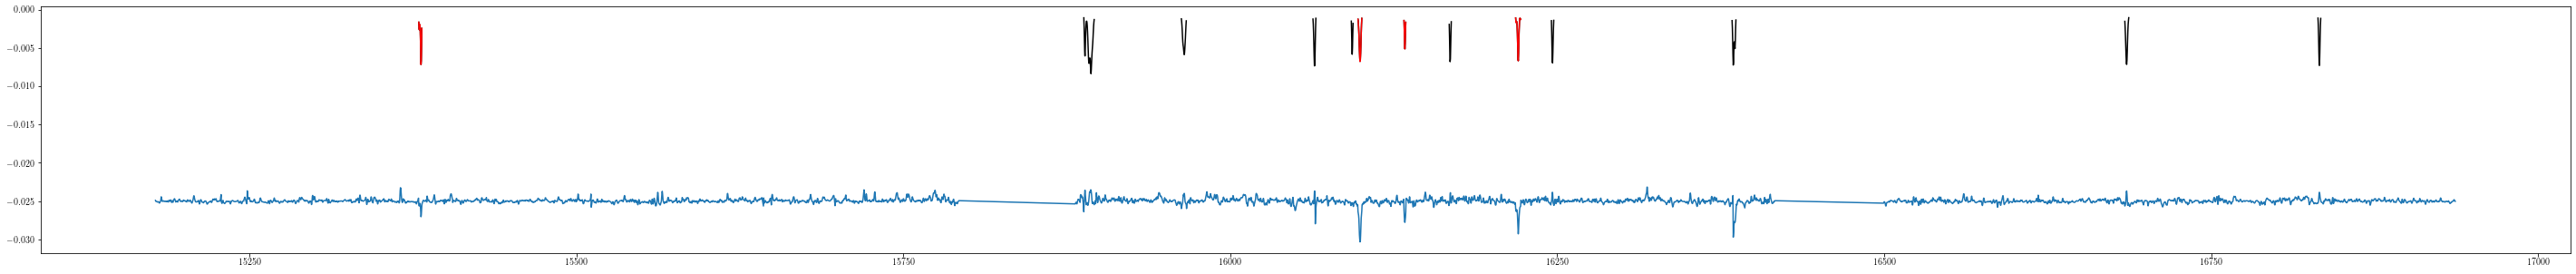

In [14]:
# Choose an element:
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],

ele_index = 6 # [Si/H]

%matplotlib inline
fig = plt.figure(figsize=(50,5))

# Plot the strong features
for i in range(len(start_count[ele_index])):
    plt.plot(wave_grid[start_count[ele_index][i]:end_count[ele_index][i]],
             gradient_spec[ele_index][start_count[ele_index][i]:end_count[ele_index][i]],
             color="black")
    
# Plot pixels that got masked out
for i in range(len(start_count_mask[ele_index])):
    plt.plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
             gradient_spec[ele_index][start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
             color='r')
    
# Plot the difference derivative between the observed output and the synthetic output (ie. J_diff)
plt.plot(wave_grid[47:], jac_diff[:,ele_index]-0.025)
    
plt.show()

Again it seems to have located the missing line for Silicon as well as placing more importance on one other line. This latter issue is not a huge problem for the real application because we will be focusing in on a particular location where an unkown line is present.

Titianium:

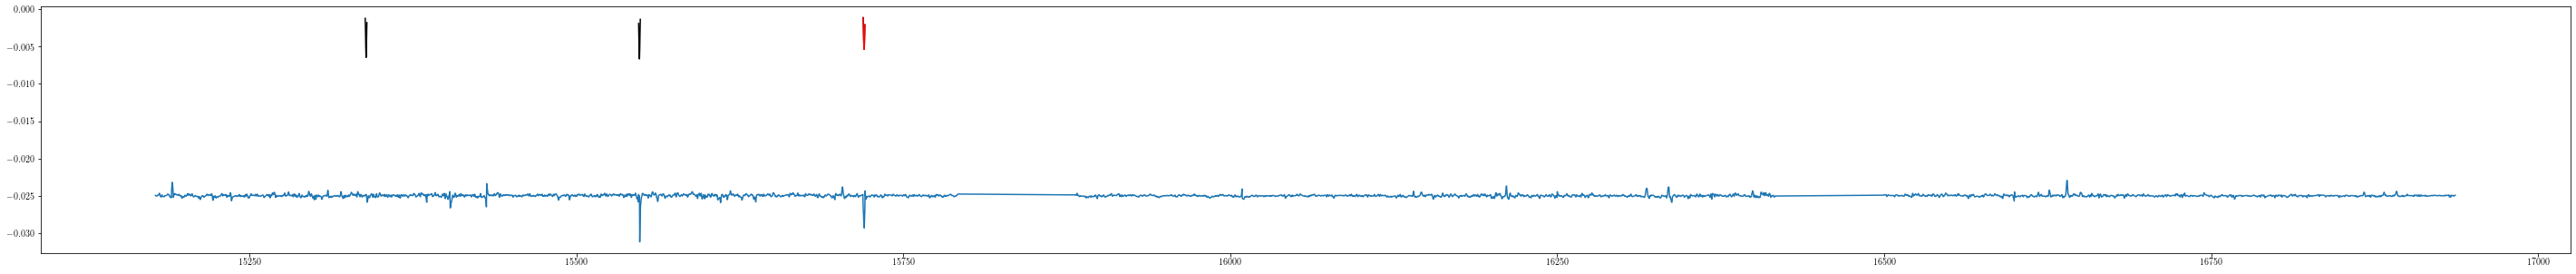

In [15]:
# Choose an element:
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],

ele_index = 11 # [Ti/H]

%matplotlib inline
fig = plt.figure(figsize=(50,5))

# Plot the strong features
for i in range(len(start_count[ele_index])):
    plt.plot(wave_grid[start_count[ele_index][i]:end_count[ele_index][i]],
             gradient_spec[ele_index][start_count[ele_index][i]:end_count[ele_index][i]],
             color="black")
    
# Plot pixels that got masked out
for i in range(len(start_count_mask[ele_index])):
    plt.plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
             gradient_spec[ele_index][start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
             color='r')
    
# Plot the difference derivative between the observed output and the synthetic output (ie. J_diff)
plt.plot(wave_grid[47:], jac_diff[:,ele_index]-0.025)
    
plt.show()

Nickel:

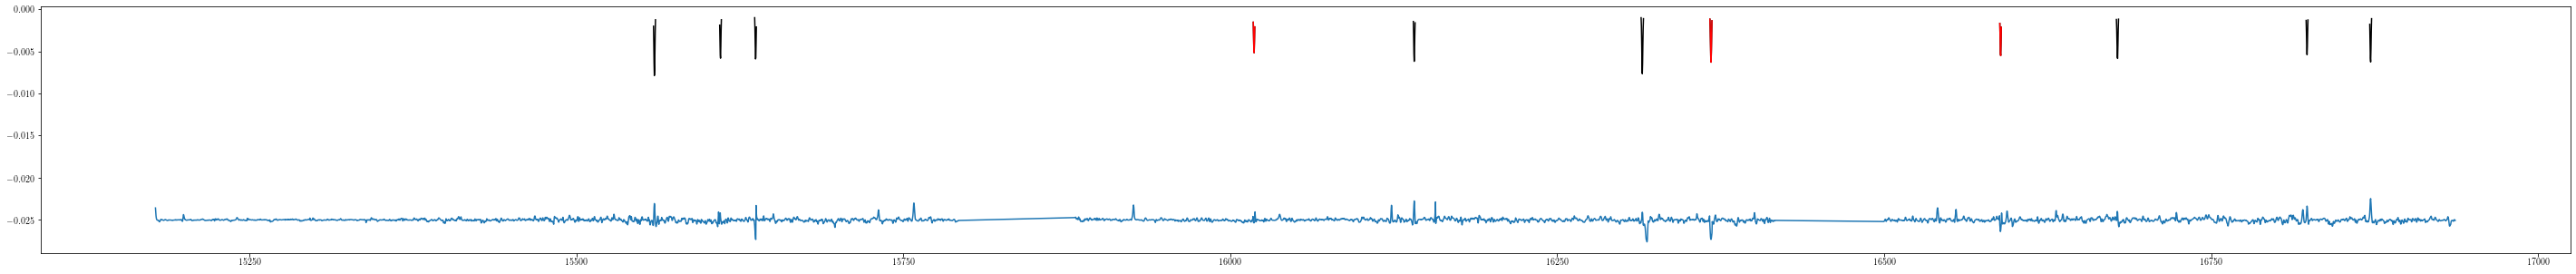

In [16]:
# Choose an element:
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],

ele_index = 17 # [Ni/H]

%matplotlib inline
fig = plt.figure(figsize=(50,5))

# Plot the strong features
for i in range(len(start_count[ele_index])):
    plt.plot(wave_grid[start_count[ele_index][i]:end_count[ele_index][i]],
             gradient_spec[ele_index][start_count[ele_index][i]:end_count[ele_index][i]],
             color="black")
    
# Plot pixels that got masked out
for i in range(len(start_count_mask[ele_index])):
    plt.plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
             gradient_spec[ele_index][start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
             color='r')
    
# Plot the difference derivative between the observed output and the synthetic output (ie. J_diff)
plt.plot(wave_grid[47:], jac_diff[:,ele_index]-0.025)
    
plt.show()

Make one nice plot that inclodes Mg, Si, and Fe in the middle chip

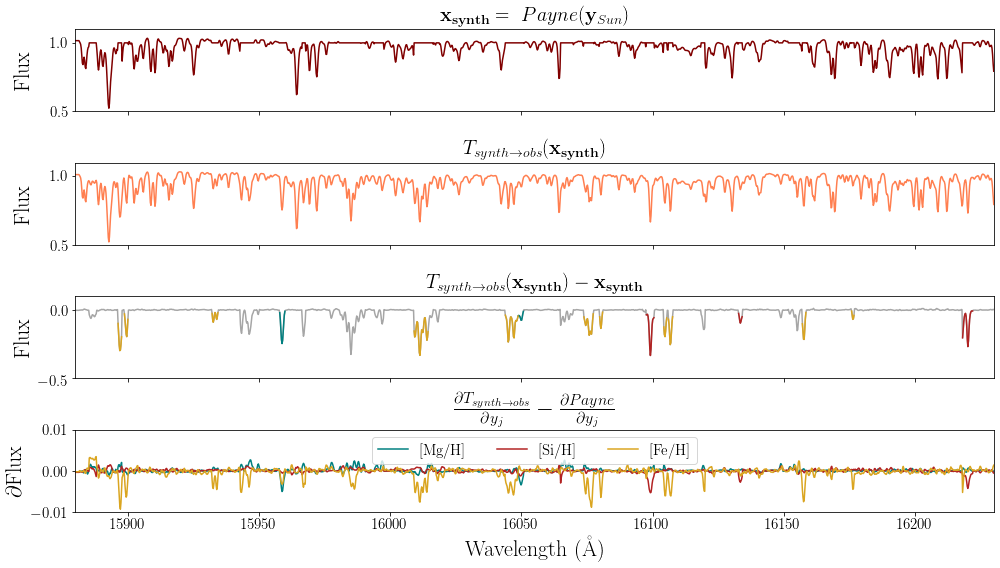

In [17]:
plt.close('all')

elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']
# Elements to include in plot
ele_indices = [4, 6, 15]

# x lims
min_wave = 15880 # in Angstroms
max_wave = 16230

wave = wave_grid[47:]

# Calculate residulal
x_resid = (x_obs.data.numpy()-x_synth)

# Add on zeros to the left to match with original wave_grid
x_resid = np.concatenate((np.zeros((1,47)),x_resid),1)

# Plot results
fig, axes = plt.subplots(4,1,figsize=(14,8), sharex=True)
# Synthetic spectrum
axes[0].plot(wave, x_synth[0], c='maroon')
# Observed spectrum
axes[1].plot(wave, x_obs[0].data.numpy(), c='coral')
# Residual
axes[2].plot(wave_grid, x_resid[0], c='grey', alpha=0.7)

# Masks and jac_diff
#colormap = plt.cm.brg
#ele_colors = [colormap(i) for i in np.linspace(0, 1, len(ele_indices))]
ele_colors = ['teal', 'firebrick','goldenrod']
for ele_index, ele_color in zip(ele_indices, ele_colors): 
    # Color the pixels that were masked out in the synthetic domain
    for i in range(len(start_count_mask[ele_index])):
        axes[2].plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
                 x_resid[0,start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
                 color=ele_color)
        
    # Plot the difference jacobian
    jac_, = axes[3].plot(wave, jac_diff[:,ele_index], 
                         c=ele_color, label=elem_labels[ele_index])        
axes[3].legend(loc='upper center', ncol=len(ele_indices), fontsize=15)

axes[0].set_xlim((min_wave,max_wave))
axes[0].set_ylim((0.5,1.1))
axes[1].set_ylim((0.5,1.1))
axes[2].set_ylim((-0.5,0.1))
axes[3].set_ylim((-0.01,0.01))
for ax in axes:
    ax.tick_params(labelsize=15)
axes[0].set_ylabel(r'Flux',fontsize=22,labelpad=15)
axes[1].set_ylabel(r'Flux',fontsize=22,labelpad=15)
axes[2].set_ylabel(r'Flux',fontsize=22)
axes[3].set_ylabel(r'$\partial$Flux',fontsize=22)

axes[0].set_title(r'$\mathbf{x_{synth}}=\ Payne(\mathbf{y}_{Sun}$)', fontsize=20)
axes[1].set_title(r'$T_{synth\rightarrow obs}(\mathbf{x_{synth}})$', fontsize=20)
axes[2].set_title(r'$T_{synth\rightarrow obs}(\mathbf{x_{synth}})-\mathbf{x_{synth}}$', fontsize=20)
axes[3].set_title(r'$\frac{\partial{T_{synth\rightarrow obs}}}{\partial{y_j}}-\frac{\partial{Payne}}{\partial{y_j}}$', fontsize=23)
plt.xlabel(r'Wavelength (\AA)',fontsize=22)
plt.tight_layout()
#plt.savefig('../figures/jac_diff.pdf', transparent=True, pad_inches=0.)
plt.show()

Carbon and Nitrogen are highly correlated and this is apparent when trying to identify which missing lines belong to which of these two elements. This is exemplified below.

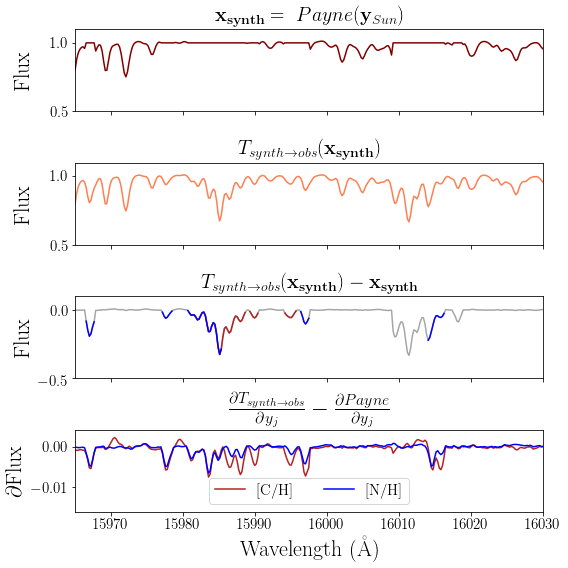

In [19]:
plt.close('all')

elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']
# Elements to include in plot
ele_indices = [0,1]

# x lims
min_wave = 15965 # in Angstroms
max_wave = 16030

wave = wave_grid[47:]

# Calculate residulal
x_resid = (x_obs.data.numpy()-x_synth)

# Add on zeros to the left to match with original wave_grid
x_resid = np.concatenate((np.zeros((1,47)),x_resid),1)

# Plot results
fig, axes = plt.subplots(4,1,figsize=(8,8), sharex=True)
# Synthetic spectrum
axes[0].plot(wave, x_synth[0], c='maroon')
# Observed spectrum
axes[1].plot(wave, x_obs[0].data.numpy(), c='coral')
# Residual
axes[2].plot(wave_grid, x_resid[0], c='grey', alpha=0.7)

# Masks and jac_diff
#colormap = plt.cm.Paired
ele_colors = ['firebrick','blue']#[colormap(i) for i in np.linspace(0, 1, len(ele_indices))]
for ele_index, ele_color in zip(ele_indices, ele_colors): 
    # Color the pixels that were masked out in the synthetic domain
    for i in range(len(start_count_mask[ele_index])):
        axes[2].plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
                 x_resid[0,start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
                 color=ele_color)
        
    # Plot the difference jacobian
    jac_, = axes[3].plot(wave, jac_diff[:,ele_index], 
                         c=ele_color, label=elem_labels[ele_index])        
axes[3].legend(loc='lower center', ncol=len(ele_indices), fontsize=15)

axes[0].set_xlim((min_wave,max_wave))
axes[0].set_ylim((0.5,1.1))
axes[1].set_ylim((0.5,1.1))
axes[2].set_ylim((-0.5,0.1))
#axes[3].set_ylim((-0.8,0.2))
for ax in axes:
    ax.tick_params(labelsize=15)
axes[0].set_ylabel(r'Flux',fontsize=22,labelpad=15)
axes[1].set_ylabel(r'Flux',fontsize=22,labelpad=15)
axes[2].set_ylabel(r'Flux',fontsize=22)
axes[3].set_ylabel(r'$\partial$Flux',fontsize=22)

axes[0].set_title(r'$\mathbf{x_{synth}}=\ Payne(\mathbf{y}_{Sun}$)', fontsize=20)
axes[1].set_title(r'$T_{synth\rightarrow obs}(\mathbf{x_{synth}})$', fontsize=20)
axes[2].set_title(r'$T_{synth\rightarrow obs}(\mathbf{x_{synth}})-\mathbf{x_{synth}}$', fontsize=20)
axes[3].set_title(r'$\frac{\partial{T_{synth\rightarrow obs}}}{\partial{y_j}}-\frac{\partial{Payne}}{\partial{y_j}}$', fontsize=23)
plt.xlabel(r'Wavelength (\AA)',fontsize=22)
plt.tight_layout()
plt.savefig('../figures/jac_diff_C_and_N.pdf', transparent=True, pad_inches=0.)
plt.show()